In [1]:
!pip install scikit-learn==1.4.2
!pip install scikeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Input,Dropout,Flatten
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


2025-04-15 21:13:13.771730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744751593.984258      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744751594.041583      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/pimas-diabetes-dataset/diabetes(PIMA).csv")

In [3]:
print("\nDataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())



Dataset shape: (768, 9)

First few rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
print("\nNull values in each column:")
print(df.isnull().sum())


Null values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [6]:
print("\nCount of zeros in each column:")
for column in df.columns:
    print(f"{column}: {(df[column] == 0).sum()}")


Count of zeros in each column:
Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


In [7]:
zero_impossible_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN in these columns
print("\nReplacing zeros with NaN in selected columns...")
for column in zero_impossible_columns:
    df[column] = df[column].replace(0, np.nan)


Replacing zeros with NaN in selected columns...


In [8]:
print("\nMissing values after zero replacement:")
print(df.isnull().sum())


Missing values after zero replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [9]:
print("\nFilling missing values with mean...")
for column in zero_impossible_columns:
    mean_value= df[column].mean()
    df[column] = df[column].fillna(mean_value)


Filling missing values with mean...


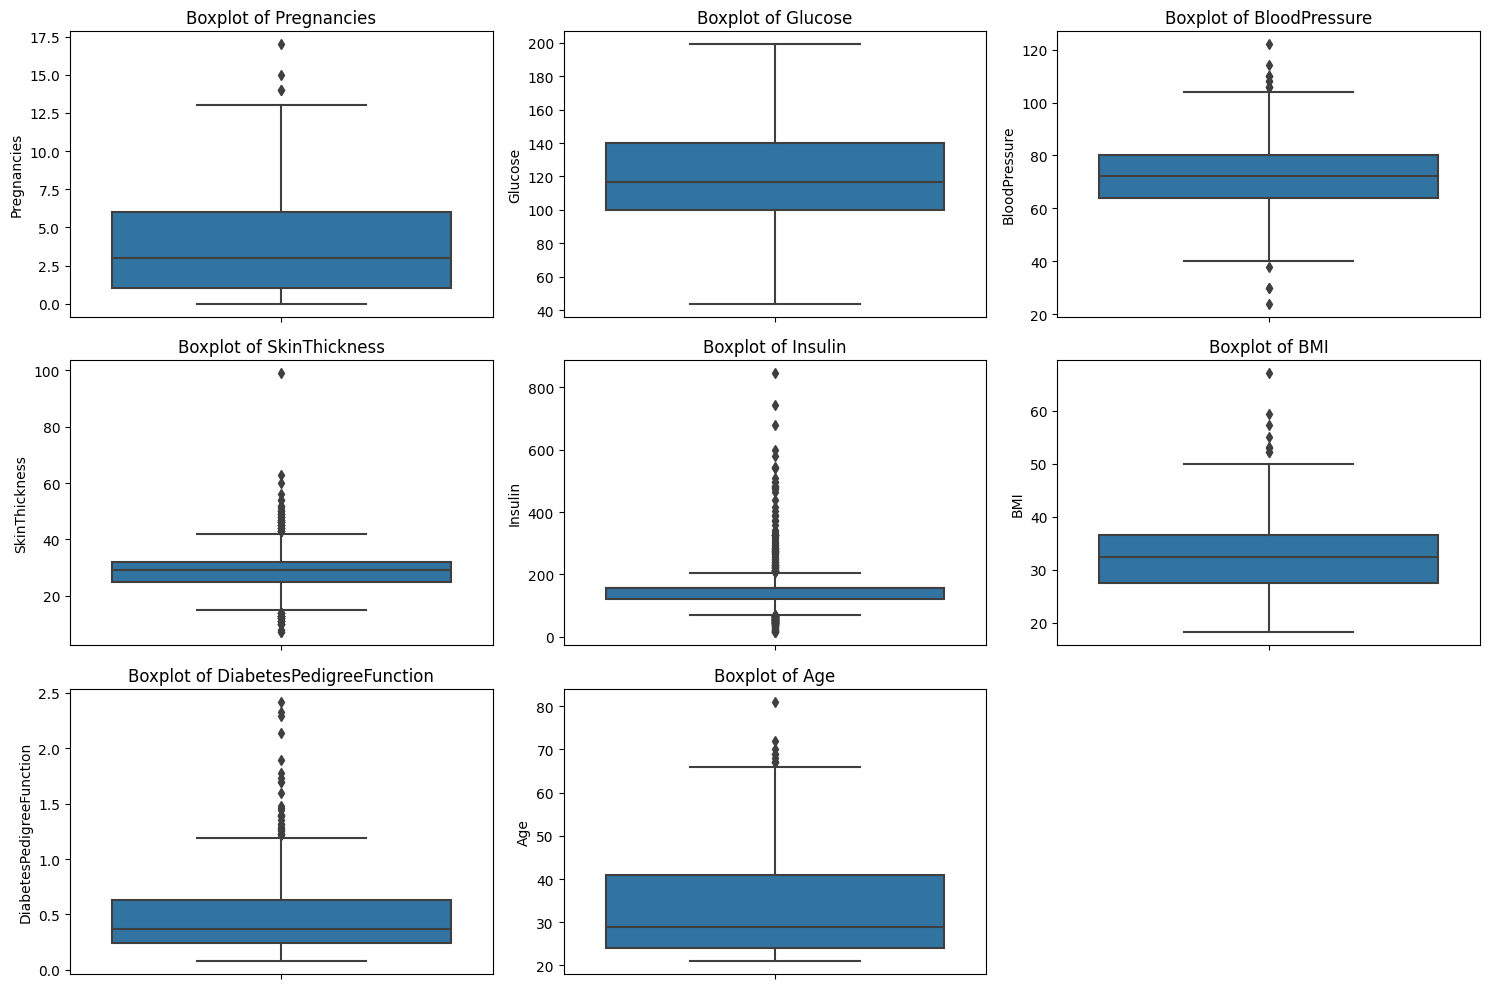

In [10]:
plt.figure(figsize=(15, 10))
numeric_columns = df.drop(columns=['Outcome']).columns  # Exclude target column

for i, column in enumerate(numeric_columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

In [11]:


def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    print(f"{column}: {outliers} outliers detected")

    # Cap the outliers instead of removing
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df

# Apply to all columns except target
for column in df.columns[:-1]:
    df= handle_outliers(df, column)


Pregnancies: 4 outliers detected
Glucose: 0 outliers detected
BloodPressure: 14 outliers detected
SkinThickness: 87 outliers detected
Insulin: 164 outliers detected
BMI: 8 outliers detected
DiabetesPedigreeFunction: 29 outliers detected
Age: 9 outliers detected


In [12]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']


In [13]:
X_unscaled = X.copy() #for RF

In [14]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import Lasso, LogisticRegression
# 1. Mutual Information feature selection
selector_mi = SelectKBest(mutual_info_classif, k='all')
selector_mi.fit(X_scaled, y)
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': selector_mi.scores_
}).sort_values(by='MI_Score', ascending=False)
print("\nMutual Information feature ranking:")
print(mi_scores)


Mutual Information feature ranking:
                    Feature  MI_Score
1                   Glucose  0.117859
7                       Age  0.082974
5                       BMI  0.081613
4                   Insulin  0.031311
0               Pregnancies  0.024217
2             BloodPressure  0.004125
3             SkinThickness  0.000000
6  DiabetesPedigreeFunction  0.000000


In [19]:
# 2. Random Forest feature importance
rf_for_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rf_for_fs.fit(X_unscaled, y)  # Use unscaled data for Random Forest
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_for_fs.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nRandom Forest feature importance:")
print(rf_importances)


Random Forest feature importance:
                    Feature  Importance
1                   Glucose    0.264177
5                       BMI    0.173415
7                       Age    0.131484
6  DiabetesPedigreeFunction    0.121556
2             BloodPressure    0.085424
0               Pregnancies    0.081640
4                   Insulin    0.073885
3             SkinThickness    0.068418


In [20]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_scaled, y)
lasso_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lasso.coef_[0])
}).sort_values(by='Coefficient', ascending=False)
print("\nLasso feature importance:")
print(lasso_importance)



Lasso feature importance:
                    Feature  Coefficient
1                   Glucose     2.837975
5                       BMI     0.654514
0               Pregnancies     0.317650
7                       Age     0.128411
6  DiabetesPedigreeFunction     0.007166
2             BloodPressure     0.000000
3             SkinThickness     0.000000
4                   Insulin     0.000000


In [21]:
import pandas as pd

# Assuming these DataFrames are already created from your previous steps:
# mi_scores = DataFrame with 'Feature' and 'MI_Score'
# rf_importances = DataFrame with 'Feature' and 'Importance'
# lasso_importance = DataFrame with 'Feature' and 'Coefficient'

# Step 1: Assign ranks (lower rank = more important)
mi_scores['MI_Rank'] = mi_scores['MI_Score'].rank(ascending=False)
rf_importances['RF_Rank'] = rf_importances['Importance'].rank(ascending=False)
lasso_importance['Lasso_Rank'] = lasso_importance['Coefficient'].rank(ascending=False)

# Step 2: Merge all ranks into one DataFrame
merged = mi_scores[['Feature', 'MI_Rank']].merge(
    rf_importances[['Feature', 'RF_Rank']], on='Feature'
).merge(
    lasso_importance[['Feature', 'Lasso_Rank']], on='Feature'
)

# Step 3: Aggregate final rank using mean or majority vote
merged['Average_Rank'] = merged[['MI_Rank', 'RF_Rank', 'Lasso_Rank']].mean(axis=1)

# Optional: You could also use majority voting for top-k if needed

# Step 4: Sort by average rank
merged_sorted = merged.sort_values(by='Average_Rank')

# Show final feature ranking
print("\nFinal Feature Ranking based on Average of Ranks:")
print(merged_sorted)



Final Feature Ranking based on Average of Ranks:
                    Feature  MI_Rank  RF_Rank  Lasso_Rank  Average_Rank
0                   Glucose      1.0      1.0         1.0      1.000000
2                       BMI      3.0      2.0         2.0      2.333333
1                       Age      2.0      3.0         4.0      3.000000
4               Pregnancies      5.0      6.0         3.0      4.666667
7  DiabetesPedigreeFunction      7.5      4.0         5.0      5.500000
3                   Insulin      4.0      7.0         7.0      6.000000
5             BloodPressure      6.0      5.0         7.0      6.000000
6             SkinThickness      7.5      8.0         7.0      7.500000


In [25]:
top_features=['Glucose','BMI','Age','BloodPressure','Pregnancies','Insulin']

In [26]:
X_selected = X[top_features]
X_selected_unscaled = X_unscaled[top_features]  # Unscaled version for Random Forest

# Scale the selected features for LSTM
X_selected_scaled = scaler.fit_transform(X_selected)

In [31]:
from imblearn.over_sampling import SMOTE
print("\nApplying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_unscaled_resampled, y_unscaled_resampled = smote.fit_resample(X_selected_unscaled, y)
X_scaled_resampled, y_scaled_resampled = smote.fit_resample(X_selected_scaled, y)
print("Class distribution before SMOTE:")
print(pd.Series(y).value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_unscaled_resampled).value_counts())



Applying SMOTE for class balancing...
Class distribution before SMOTE:
Outcome
0    500
1    268
Name: count, dtype: int64

Class distribution after SMOTE:
Outcome
1    500
0    500
Name: count, dtype: int64


In [33]:
from sklearn.model_selection import KFold, cross_val_score
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_results = cross_val_score(rf_model, X_unscaled_resampled, y_unscaled_resampled, cv=kfold, scoring='accuracy')

In [34]:
print(f"Random Forest CV Accuracy: {rf_cv_results.mean():.4f} (+/- {rf_cv_results.std():.4f})")

Random Forest CV Accuracy: 0.8190 (+/- 0.0188)


In [35]:
rf_model.fit(X_unscaled_resampled, y_unscaled_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [36]:
print("\n----- TRAIN-TEST SPLIT -----")

# Split the unscaled data for final RF evaluation
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(
    X_unscaled_resampled, y_unscaled_resampled, test_size=0.2, random_state=42, stratify=y_unscaled_resampled
)


----- TRAIN-TEST SPLIT -----


In [37]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled_resampled, y_scaled_resampled, test_size=0.2, random_state=42, stratify=y_scaled_resampled
)

print(f"Training set size: {X_train_unscaled.shape}")
print(f"Testing set size: {X_test_unscaled.shape}")

Training set size: (800, 6)
Testing set size: (200, 6)


In [38]:
rf_train_proba = rf_model.predict_proba(X_train_unscaled)
rf_test_proba = rf_model.predict_proba(X_test_unscaled)

In [39]:
print("\n----- PREPARING DATA FOR LSTM -----")

# Combine original features with RF probabilities
train_features_with_rf = np.hstack((X_train_scaled, rf_train_proba))
test_features_with_rf = np.hstack((X_test_scaled, rf_test_proba))


----- PREPARING DATA FOR LSTM -----


In [40]:
lstm_X_train = train_features_with_rf.reshape(train_features_with_rf.shape[0], 1, train_features_with_rf.shape[1])
lstm_X_test = test_features_with_rf.reshape(test_features_with_rf.shape[0], 1, test_features_with_rf.shape[1])

print(f"LSTM input shape: {lstm_X_train.shape}")

LSTM input shape: (800, 1, 8)


In [51]:
print("\n----- LSTM MODEL TRAINING -----")

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)



----- LSTM MODEL TRAINING -----


In [43]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create a wrapper for k-fold cross-validation
lstm_model = KerasClassifier(
    build_fn=create_lstm_model,
    epochs=100,
    batch_size=32,
    verbose=0
)

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
lstm_cv_results = cross_val_score(lstm_model, lstm_X_train, y_train_scaled, cv=kfold)

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
I0000 00:00:1744752979.148085      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744752983.283953     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use 

In [52]:
print(f"LSTM CV Accuracy: {lstm_cv_results.mean():.4f} (+/- {lstm_cv_results.std():.4f})")


LSTM CV Accuracy: 0.9500 (+/- 0.0172)


In [53]:
# Train the final LSTM model
final_lstm_model = create_lstm_model()
history = final_lstm_model.fit(
    lstm_X_train, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3774 - loss: 0.6959 - val_accuracy: 0.7063 - val_loss: 0.6748
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7152 - loss: 0.6676 - val_accuracy: 0.7750 - val_loss: 0.6462
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7904 - loss: 0.6378 - val_accuracy: 0.8000 - val_loss: 0.6141
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8137 - loss: 0.6081 - val_accuracy: 0.8250 - val_loss: 0.5760
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8658 - loss: 0.5624 - val_accuracy: 0.8375 - val_loss: 0.5295
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8926 - loss: 0.5038 - val_accuracy: 0.8500 - val_loss: 0.4771
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9184 - loss: 0.4493 - val_accuracy: 0.8687 - val_loss: 0.4226
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9343 - loss: 0.3879 - val_accuracy: 0.8687 - val_loss

In [54]:
print("\n----- MODEL EVALUATION -----")

# Evaluate Random Forest on test set
y_rf_pred = rf_model.predict(X_test_unscaled)
y_rf_pred_proba = rf_model.predict_proba(X_test_unscaled)[:, 1]



----- MODEL EVALUATION -----


In [55]:
print("\nRandom Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_unscaled, y_rf_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_unscaled, y_rf_pred))
print("\nClassification Report:")
print(classification_report(y_test_unscaled, y_rf_pred))



Random Forest Evaluation:
Accuracy: 0.9550

Confusion Matrix:
[[92  8]
 [ 1 99]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       100
           1       0.93      0.99      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



In [56]:
y_lstm_pred_proba = final_lstm_model.predict(lstm_X_test)
y_lstm_pred = (y_lstm_pred_proba > 0.5).astype(int).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [57]:
print("\nStacked RF-LSTM Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_scaled, y_lstm_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_scaled, y_lstm_pred))
print("\nClassification Report:")
print(classification_report(y_test_scaled, y_lstm_pred))


Stacked RF-LSTM Model Evaluation:
Accuracy: 0.9700

Confusion Matrix:
[[96  4]
 [ 2 98]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.96      0.98      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



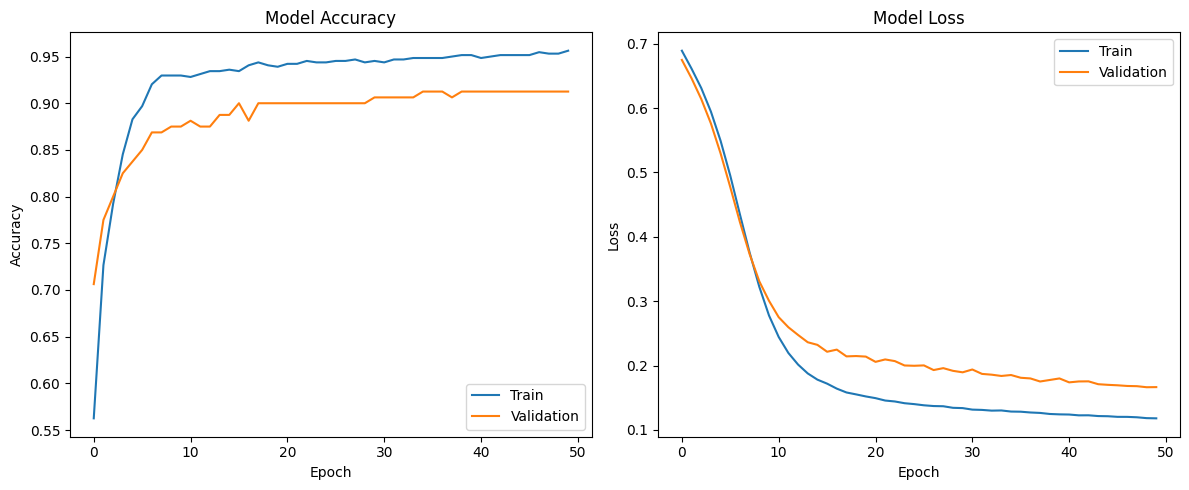

In [59]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()

plt.show()

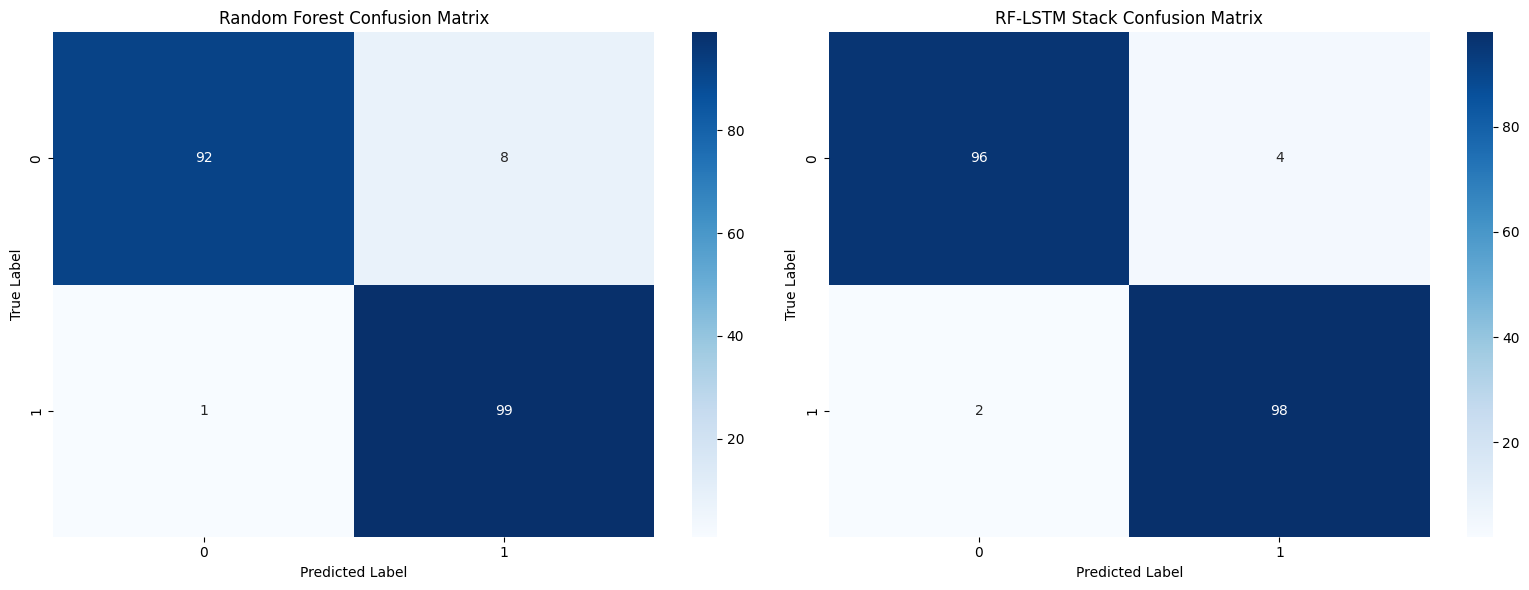

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(confusion_matrix(y_test_unscaled, y_rf_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')
sns.heatmap(confusion_matrix(y_test_scaled, y_lstm_pred), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('RF-LSTM Stack Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

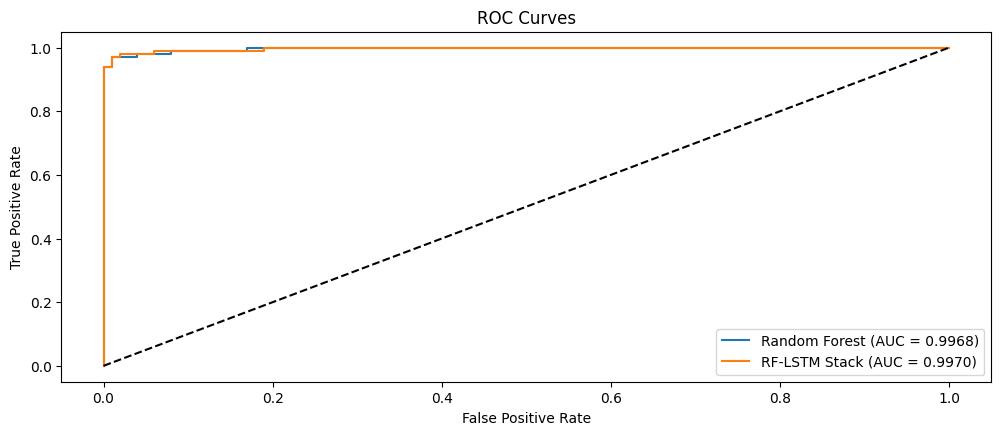

In [71]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
rf_fpr, rf_tpr, _ = roc_curve(y_test_unscaled, y_rf_pred_proba)
rf_auc = auc(rf_fpr, rf_tpr)

lstm_fpr, lstm_tpr, _ = roc_curve(y_test_scaled, y_lstm_pred_proba)
lstm_auc = auc(lstm_fpr, lstm_tpr)
# Plot ROC curves
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(lstm_fpr, lstm_tpr, label=f'RF-LSTM Stack (AUC = {lstm_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

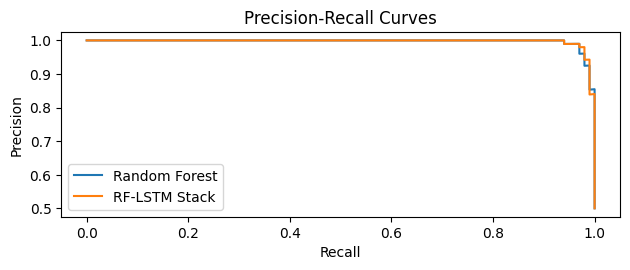

In [73]:
rf_precision, rf_recall, _ = precision_recall_curve(y_test_unscaled, y_rf_pred_proba)
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test_scaled, y_lstm_pred_proba)

# Plot PR curves
plt.subplot(2, 1, 2)
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(lstm_recall, lstm_precision, label='RF-LSTM Stack')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()